# Linear Regression

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [2]:
def load_fish_data(file_path="data"):
    csv_path = os.path.join(file_path, "Fish.csv")
    return pd.read_csv(csv_path)

In [3]:
fishes = load_fish_data()
fishes.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
fishes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
Species    159 non-null object
Weight     159 non-null float64
Length1    159 non-null float64
Length2    159 non-null float64
Length3    159 non-null float64
Height     159 non-null float64
Width      159 non-null float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [5]:
fishes["Species"].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [6]:
fishes.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


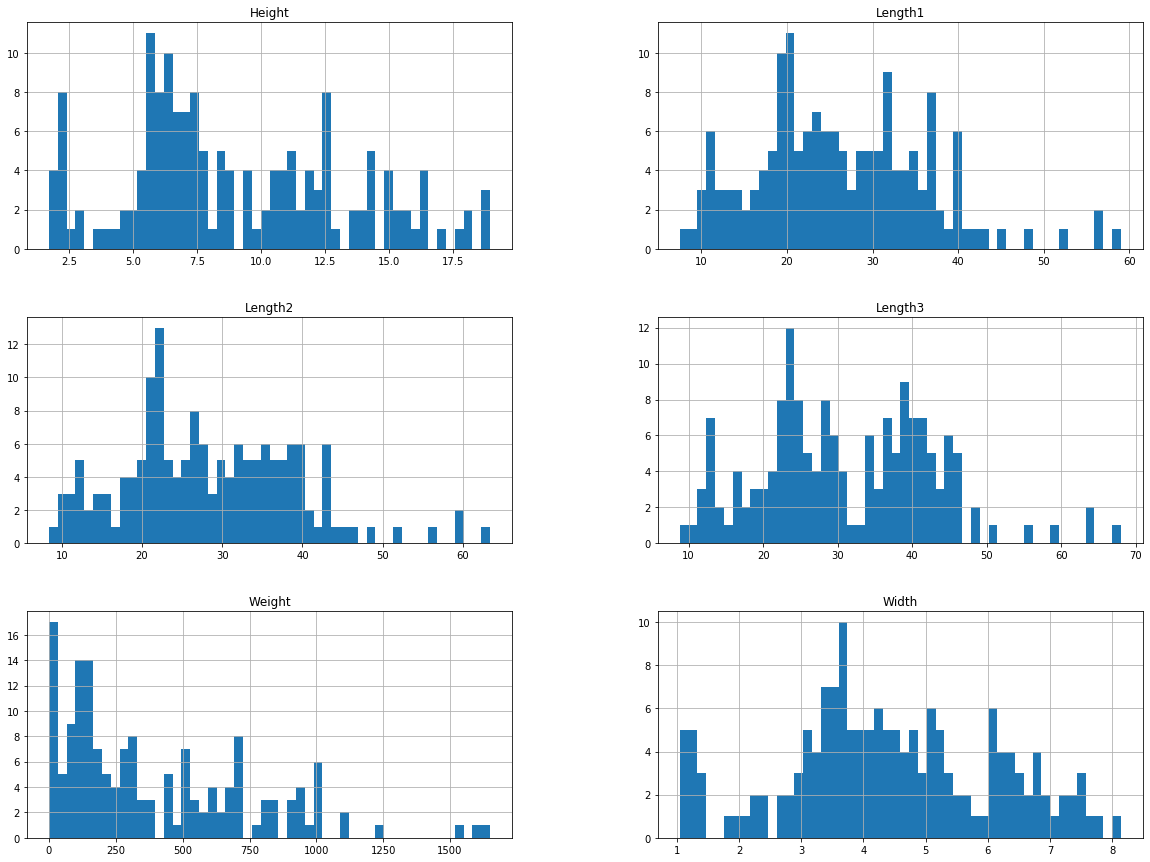

In [7]:
fishes.hist(bins=50, figsize=(20,15))
plt.show()

## Create Trainingset

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(fishes, fishes["Species"]):
    strat_train_set = fishes.loc[train_index]
    strat_test_set = fishes.loc[test_index]

In [10]:
strat_test_set["Species"].value_counts() / len(strat_test_set)

Perch        0.34375
Bream        0.21875
Roach        0.12500
Pike         0.12500
Smelt        0.09375
Parkki       0.06250
Whitefish    0.03125
Name: Species, dtype: float64

In [11]:
fishes["Species"].value_counts() / len(fishes)

Perch        0.352201
Bream        0.220126
Roach        0.125786
Pike         0.106918
Smelt        0.088050
Parkki       0.069182
Whitefish    0.037736
Name: Species, dtype: float64

In [12]:
fishes_plot = strat_train_set
fishes = strat_train_set.drop("Weight", axis=1)
fishes_labels = strat_train_set["Weight"].copy()

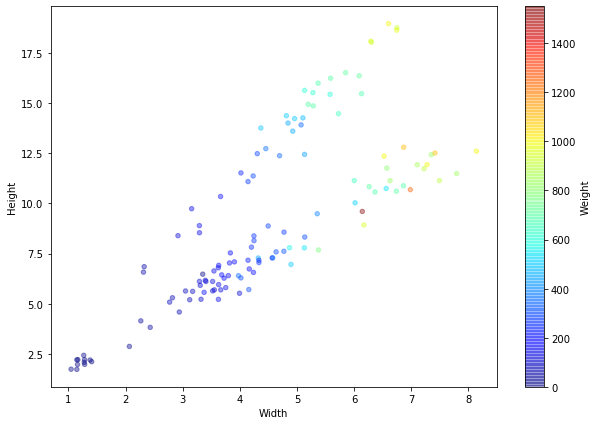

In [13]:
fishes_plot.plot(
    kind="scatter", 
    x="Width", 
    y ="Height", 
    alpha=0.4, 
    figsize=(10,7),
    c="Weight", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True,
    sharex=False)

## Plot Data

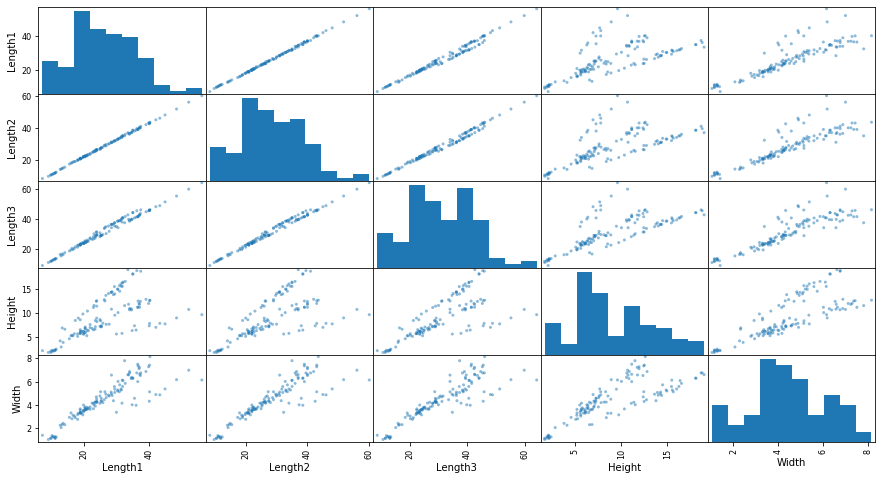

In [14]:
from pandas.plotting import scatter_matrix

attributes = ["Length1","Length2","Length3","Height","Width"]
scatter_matrix(fishes[attributes], figsize=(15,8));

## Build pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

fishes_num = fishes.drop("Species", axis=1)

num_pipeline = Pipeline([
 ("std_scaler", StandardScaler()),
 ("poly", PolynomialFeatures(degree=2))
])

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(fishes_num)
cat_attribs = ["Species"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
])

fishes_prepared = full_pipeline.fit_transform(fishes)

## Train data
### LinearRegression

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(fishes_prepared, fishes_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
some_data = fishes.iloc[:5]
some_labels = fishes_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [217.73389181  11.00660537  93.80993917 274.88518535 639.72678337]
Labels: [200.0, 9.8, 80.0, 242.0, 685.0]


In [19]:
from sklearn.metrics import mean_squared_error

fishes_predictions = lin_reg.predict(fishes_prepared)
lin_mse = mean_squared_error(fishes_labels, fishes_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

41.43332983816569

In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, fishes_prepared, fishes_labels, cv=5)
scores

array([0.95249216, 0.97285514, 0.81003758, 0.94742355, 0.98049658])

## Test model

In [21]:
fishes_test = strat_test_set.drop("Weight", axis=1)
fishes_test_labels = strat_test_set["Weight"].copy()

In [22]:
fishes_test_prepared = full_pipeline.fit_transform(fishes_test)

In [23]:
final_predictions = lin_reg.predict(fishes_test_prepared)

In [24]:
final_mse = mean_squared_error(fishes_test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [25]:
print(final_mse)
print(final_rmse)

10333.610144324372
101.65436608589113
